## 목차

1. 프로젝트 개요  
 1.1. 문제 정의 및 목표  
 1.2. 데이터셋 설명  
 1.3. 평가 지표  

2. 환경 설정 및 데이터 준비  
 2.1. 환경 설정  
 2.2. 데이터 다운로드 및 구조 확인  

3. 데이터셋 구축 및 시각화  
 3.1. 어노테이션 파싱 및 데이터셋 구성  
 3.2. 전처리/Transform 정의  
 3.3. DataLoader 정의  
 3.4. Bounding Box 시각화  

4. SSD 모델 구현 및 학습  
 4.1. SSD 모델 구성 및 설정  
 4.2. Optimizer·스케줄러·손실/지표 구현  
 4.3. 학습·검증 루프 및 mAP 계산  

5. 테스트 추론 및 결과 분석  
 5.1. 테스트셋 추론 및 시각화  
 5.2. 성능 분석 및 오류 사례  
 5.3. 결론 및 개선 방향  

## 1. 프로젝트 개요

### 1.1. 문제 정의 및 목표

- 이 프로젝트는 Oxford-IIIT Pet Dataset의 이미지를 바탕으로, 개와 고양이의 얼굴 영역을 SSD(Single Shot Multibox Detector) 모델로 탐지하는 객체 검출 모델을 개발하는 것을 목표로 한다.

- 사전학습된 SSD300 모델을 기반으로 데이터셋에 맞게 재학습(fine-tuning)하고, 검증·테스트 이미지에서 얼굴 위치(Bounding Box)와 클래스(개/고양이)를 정확하게 예측하는 성능을 확보하는 것이 핵심 목표이다.

### 1.2. 데이터셋 설명

- 출처: Kaggle에 공개된 Oxford-IIIT Pet Dataset 기반 반려동물 이미지·어노테이션 데이터셋

- 구성: 여러 품종의 개·고양이 이미지와, 각 이미지에 대해 XML 형식으로 제공되는 얼굴 영역 Bounding Box 및 클래스 정보(cat/dog)

### 1.3. 평가 지표

- 모델 성능 평가는 객체 검출에서 널리 사용하는 IoU(Intersection over Union) 와 mAP(mean Average Precision) 을 중심으로 수행한다.

- IoU로 예측 박스와 정답 박스의 겹침 정도를 측정하고, 클래스별 AP(Average Precision)를 계산한 뒤 평균해 mAP를 산출하며, 특히 IoU 기준 0.5 이상에서 mAP(mAP@0.5) 을 주요 비교 지표로 사용한다.  
    *테스트셋에는 정답 annotation이 제공되지 않아 mAP·IoU 등 정량적 평가는 validation set에서만 산출하였음.

## 2. 환경 설정 및 데이터 준비

### 2.1. 환경 설정

- 기본 라이브러리 임포트
- GPU 장치 사용 가능 여부 확인

In [1]:
# 필수 라이브러리 임포트
import torch
import torchvision
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
# 연산 장치 설정 (GPU 사용 가능 시 cuda, 아니면 cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 2.2. 데이터 다운로드 및 구조 확인

- 폴더 구조
```markdown
(상위 경로 생략)\MISSION7  
├─ 미션 파일.ipynb  
└─ data  
   ├─ annotations  
   │  ├─ trimaps  
   │  └─ xmls  
   └─ images  
      └─ images  
```

- 사전에 다운로드 한 Oxford-IIIT Pet Dataset 이미지 및 어노테이션 경로 설정  
*로컬 환경에서 데이터셋을 다운로드 한 이후에 진행하여 별도 다운로드 코드는 첨부하지 않았음.

In [3]:
# 로컬 환경 데이터 경로 예시
base_path = "./data"  # 상대 경로 지정

image_dir = os.path.join(base_path, "images", "images")
xml_dir = os.path.join(base_path, "annotations", "xmls")

trainval_file = os.path.join(base_path, "annotations", "trainval.txt")
test_file = os.path.join(base_path, "annotations", "test.txt")

# 이후 동일하게 pandas로 csv 읽기 및 파일 리스트 확인 진행

In [4]:
# CSV 파일로부터 데이터 로드 및 컬럼 이름 지정
df_trainval = pd.read_csv(trainval_file, sep="\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

df_test = pd.read_csv(test_file, sep="\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# trainval, test 데이터 크기 출력
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# 이미지 리스트 준비
trainval_list = df_trainval['Image'].tolist()
test_list = df_test['Image'].tolist()

# xml 파일 리스트 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")


Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


## 3. 데이터셋 구축 및 시각화

### 3.1. 어노테이션 파싱 및 데이터셋 구성

- XML 어노테이션을 파싱하여 이미지별로 바운딩 박스와 클래스 정보를 수집하여 리스트로 저장

- trainval 이미지 리스트와 XML 파일을 비교하여 누락된 XML 파일 확인

In [5]:
import xml.etree.ElementTree as ET

# XML 파일 리스트 가져오기
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]

# 이미지 리스트 및 어노테이션 유효성 확인
image_list = df_trainval['Image'].tolist()
existing_xmls = [os.path.splitext(file)[0] for file in xml_files]
valid_images = [img for img in image_list if img in existing_xmls]

missing_xmls = [img for img in image_list if img not in existing_xmls]
print(f"XML 없는 이미지 수: {len(missing_xmls)}")
print("XML 없는 이미지 예시:", missing_xmls[:5])

# 모든 XML을 파싱하여 어노테이션 수집
annotations = []

for xml_file in xml_files:
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_name = root.find("filename").text.split('.')[0]

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        annotations.append({
            "image": image_name,
            "class": class_name,
            "bbox": [xmin, ymin, xmax, ymax]
        })

print(f"총 어노테이션 개수: {len(annotations)}")

XML 없는 이미지 수: 9
XML 없는 이미지 예시: ['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14']
총 어노테이션 개수: 3687


- XML 없는 9개 이미지 데이터는 올바르게 학습/검증/모델 평가에서 제외 처리되었음.

### 3.2. 전처리/Transform 정의

- 기본 전처리: 이미지 텐서화, float32로 Dtype 변경

In [6]:
# 기본 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지 데이터를 Tensor 형식으로 변환
    transforms.ConvertImageDtype(torch.float32),  # float32 타입 스케일링 (0~1)
])

### 3.3. DataLoader 정의

- 커스텀 데이터셋(VOCDataset)을 정의하고, 학습·검증·테스트에 사용할 DataLoader 생성

- 데이터셋 클래스는 각 이미지 파일과 XML 어노테이션을 읽어, 바운딩 박스와 클래스 라벨(훈련/검증시), 또는 이미지와 파일명(테스트시)을 반환할 수 있도록 구성

- DataLoader는 미니배치 단위로 데이터를 공급하며, 객체 검출 문제 특성상 collate_fn(튜플 방식)을 적용해 다양한 크기의 타깃(batch)도 처리할 수 있음

In [7]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, xml_dir, classes, image_list, transforms=None, is_test=False):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.classes = classes
        self.image_list = image_list
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.image_dir, image_name + ".jpg")
        image = Image.open(image_path).convert("RGB")

        if self.is_test:
            # test 모드: annotation 사용 안 함, 이미지와 파일명만 반환
            if self.transforms is not None:
                image = self.transforms(image)
            return image, image_name
        else:
            # train/val 모드: annotation 사용
            xml_path = os.path.join(self.xml_dir, image_name + ".xml")
            boxes, labels = [], []
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in self.classes:
                    continue
                labels.append(self.classes.index(class_name))
                bndbox = obj.find("bndbox")
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)
                boxes.append([xmin, ymin, xmax, ymax])
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

            if self.transforms is not None:
                image = self.transforms(image)

            target = {'boxes': boxes, 'labels': labels}
            return image, target

- **테스트셋은 annotation이 없으므로, 정량 평가(mAP 등)는 불가하며, 정성적(시각화) 평가 목적의 데이터로더만 사용함**

- test_loader 의 경우, 테스트 이미지가 순서대로 나열될 경우, 한 품종(예: 고양이)에 치우칠 수 있음.  
    → 다양한 품종의 예측 결과를 골고루 확인하고자 test_loader에서 shuffle=True를 적용함.

In [8]:
from sklearn.model_selection import train_test_split

# 클래스 리스트 (background, dog, cat)
classes = ["background", "dog", "cat"]

# train/val split
train_list, val_list = train_test_split(valid_images, test_size=0.3, random_state=42)

# train/val 데이터셋 및 로더 생성
train_dataset = VOCDataset(image_dir, xml_dir, classes, train_list, transforms=transform)
val_dataset = VOCDataset(image_dir, xml_dir, classes, val_list, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# test 데이터셋 및 로더 생성 (is_test=True)
test_dataset = VOCDataset(image_dir, xml_dir, classes, test_list, transforms=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

### 3.4. Bounding Box 시각화

- 이미지 위에 바운딩 박스 도식화, 어노테이션 적절한지 시각적으로 확인
- 클래스명도 함께 표시하여 데이터 품질 검증

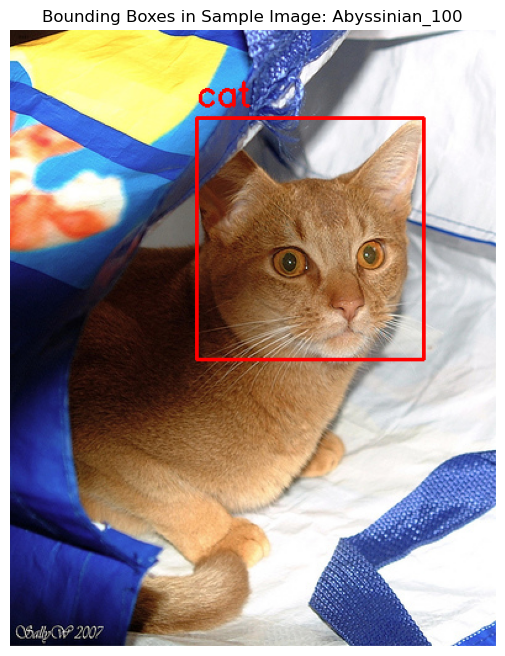

In [9]:
# 임의 이미지와 해당 어노테이션 선택
sample_image_name = valid_images[0]
sample_image_path = os.path.join(image_dir, sample_image_name + ".jpg")

# 이미지 로드 및 RGB 변환
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 해당 이미지 어노테이션 가져오기
sample_annos = [anno for anno in annotations if anno["image"] == sample_image_name]

# 바운딩 박스와 클래스명 그리기
for anno in sample_annos:
    xmin, ymin, xmax, ymax = anno["bbox"]
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)
    cv2.putText(image, anno["class"], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# 시각화
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(f"Bounding Boxes in Sample Image: {sample_image_name}")
plt.show()

## 4. SSD 모델 구현 및 학습

### 4.1. SSD 모델 구성 및 설정

- SSD300은 300x300 크기 입력 처리, VGG16 백본을 사용해 다양한 크기의 feature map에서 바운딩 박스를 예측

- 클래스 수를 num_classes에 맞게 수정하여 반려동물 얼굴 탐지 문제에 적합하도록 조정

In [10]:
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

# 클래스 정의 (background 포함)
classes = ["background", "dog", "cat"]
num_classes = len(classes)

# 사전학습된 SSD300 VGG16 모델 불러오기 및 GPU 할당
weights = SSD300_VGG16_Weights.DEFAULT
model = torchvision.models.detection.ssd300_vgg16(weights=weights)
model.head.classification_head.num_classes = num_classes
model.to(device)

print(f"Model loaded with {num_classes} classes.")

Model loaded with 3 classes.


### 4.2. Optimizer·스케줄러·손실/지표 구현

- SGD 옵티마이저와 StepLR 스케줄러를 사용해 모델 학습률 조절

- IoU 계산 함수는 예측/정답 박스 간 겹침 정도를 구함

- mAP 함수는 클래스별 AP를 산출 후 평균을 구하여 모델 전체 성능을 평가함  
    *IoU 기준 0.5 이상에서 mAP를 계산한다.(iou_thresh=0.5)

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Optimizer와 LR 스케줄러 설정
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# IoU 계산 함수
def calculate_iou(box, boxes):
    x_min = np.maximum(box[0], boxes[:, 0])
    y_min = np.maximum(box[1], boxes[:, 1])
    x_max = np.minimum(box[2], boxes[:, 2])
    y_max = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - inter_area
    iou = inter_area / (union_area + 1e-6)
    return iou

# Detection AP 누적 방식 구현
def evaluate_model(predictions, ground_truths, classes, iou_thresh=0.5):
    class_aps = []
    for cls_idx in range(1, len(classes)):
        tp = []
        fp = []
        scores = []
        npos = 0

        for pred, gt in zip(predictions, ground_truths):
            pred_boxes = pred["boxes"][pred["labels"] == cls_idx].cpu().numpy()
            pred_scores = pred["scores"][pred["labels"] == cls_idx].cpu().numpy()
            gt_boxes = gt["boxes"][gt["labels"] == cls_idx].cpu().numpy()
            npos += len(gt_boxes)

            matched = np.zeros(len(gt_boxes))
            for box, score in zip(pred_boxes, pred_scores):
                if len(gt_boxes) > 0:
                    ious = calculate_iou(box, gt_boxes)
                    max_iou_idx = np.argmax(ious)
                    max_iou = ious[max_iou_idx]
                    if max_iou >= iou_thresh and matched[max_iou_idx] == 0:
                        tp.append(1)
                        fp.append(0)
                        matched[max_iou_idx] = 1
                    else:
                        tp.append(0)
                        fp.append(1)
                else:
                    tp.append(0)
                    fp.append(1)
                scores.append(score)

        if len(scores) == 0:
            class_aps.append(0.0)
            continue

        # Confidence 기준 정렬 후 누적합
        indices = np.argsort(-np.array(scores))
        tp = np.array(tp)[indices]
        fp = np.array(fp)[indices]

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        recalls = tp_cumsum / (npos + 1e-6)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        # AP 누적(11-point interpolation 대신 실제 구간별 면적 총합)
        ap = 0.0
        for i in range(1, len(precisions)):
            ap += (recalls[i] - recalls[i-1]) * precisions[i]
        class_aps.append(ap)

    mAP = np.mean(class_aps)
    return mAP

### 4.3. 학습·검증 루프 및 mAP 계산

- 학습 루프에서 epoch마다 배치별 loss를 계산해 역전파하며 optimizer로 파라미터 업데이트

- 검증 루프에서는 gradient를 끄고 모델 예측값을 저장해 mAP를 산출하여 성능 변화 모니터링

- 학습률 스케줄러는 지정된 주기마다 학습률을 조정해 안정적인 학습을 도움

In [12]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} 시작")

    # Train
    model.train()
    train_loss = 0
    for images, targets in tqdm(train_loader, desc="Train"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation"):
            images = [img.to(device) for img in images]
            preds = model(images)
            all_preds.extend(preds)
            all_gts.extend(targets)

    val_mAP = evaluate_model(all_preds, all_gts, classes)
    print(f"Epoch {epoch+1} Validation mAP: {val_mAP:.4f}")

    lr_scheduler.step()

Epoch 1/5 시작


Train: 100%|█████████████████████████████████████████████████████████████████████████| 322/322 [01:34<00:00,  3.42it/s]


Epoch 1 Train Loss: 2.5579


Validation: 100%|████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.45it/s]


Epoch 1 Validation mAP: 0.9647
Epoch 2/5 시작


Train: 100%|█████████████████████████████████████████████████████████████████████████| 322/322 [01:39<00:00,  3.25it/s]


Epoch 2 Train Loss: 1.4351


Validation: 100%|████████████████████████████████████████████████████████████████████| 138/138 [00:56<00:00,  2.46it/s]


Epoch 2 Validation mAP: 0.9583
Epoch 3/5 시작


Train: 100%|█████████████████████████████████████████████████████████████████████████| 322/322 [01:37<00:00,  3.31it/s]


Epoch 3 Train Loss: 1.0677


Validation: 100%|████████████████████████████████████████████████████████████████████| 138/138 [00:54<00:00,  2.52it/s]


Epoch 3 Validation mAP: 0.9761
Epoch 4/5 시작


Train: 100%|█████████████████████████████████████████████████████████████████████████| 322/322 [01:34<00:00,  3.41it/s]


Epoch 4 Train Loss: 0.6507


Validation: 100%|████████████████████████████████████████████████████████████████████| 138/138 [00:54<00:00,  2.53it/s]


Epoch 4 Validation mAP: 0.9845
Epoch 5/5 시작


Train: 100%|█████████████████████████████████████████████████████████████████████████| 322/322 [01:32<00:00,  3.49it/s]


Epoch 5 Train Loss: 0.5378


Validation: 100%|████████████████████████████████████████████████████████████████████| 138/138 [00:52<00:00,  2.63it/s]


Epoch 5 Validation mAP: 0.9831


## 5. 테스트 추론 및 결과 분석

### 5.1. 테스트셋 추론 및 시각화

- 학습이 완료된 SSD 모델을 테스트 이미지에 적용하여 각 이미지에서 개와 고양이 얼굴의 바운딩 박스와 클래스를 예측함

- 각 예측 결과에 대해 scores(신뢰도) 기준으로 바운딩 박스를 시각화해, 실제 감지 성능을 육안 평가 가능함

- 샘플 20개를 시각화하여, 전체적인 성능을 평가함.

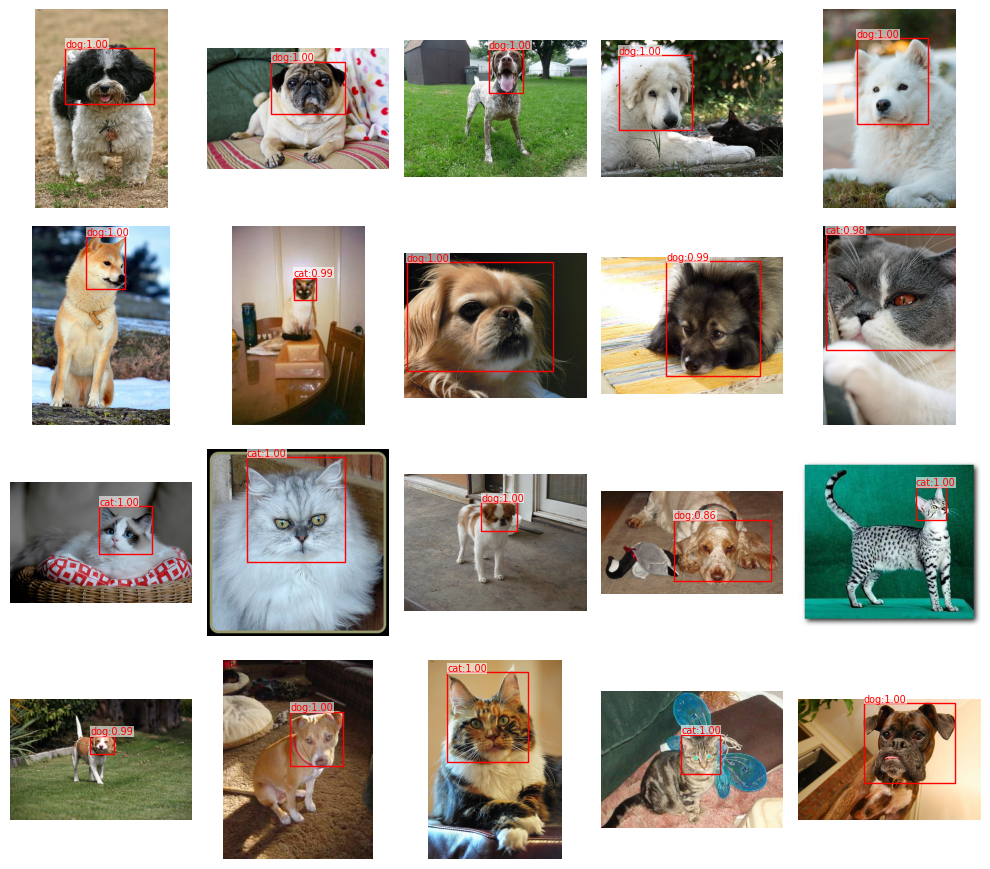

In [14]:
import matplotlib.patches as patches

def visualize_predictions_grid(images, predictions, classes, score_threshold=0.5, grid_shape=(4, 5)):
    n_images = len(images)
    n_rows, n_cols = grid_shape
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2.2))
    axes = axes.flatten()
    
    for idx, (img, pred) in enumerate(zip(images, predictions)):
        ax = axes[idx]
        image_np = img.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        # Draw bounding boxes
        for box, label, score in zip(pred["boxes"], pred["labels"], pred["scores"]):
            if score > score_threshold:
                x_min, y_min, x_max, y_max = box.tolist()
                width, height = x_max - x_min, y_max - y_min
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor="red", facecolor="none")
                ax.add_patch(rect)
                ax.text(
                    x_min, y_min - 3,
                    f"{classes[label]}:{score:.2f}",
                    color="red", fontsize=7,
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.3)
                )
        ax.axis("off")
    # Hide unused subplots (if any)
    for j in range(idx + 1, n_rows * n_cols):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

# 20개 샘플 시각화
model.eval()
max_visualizations = 20
images_collected = []
predictions_collected = []

with torch.no_grad():
    for images, image_names in test_loader:
        images = [img.to(device) for img in images]
        preds = model(images)
        for img, pred in zip(images, preds):
            if len(images_collected) < max_visualizations:
                images_collected.append(img.cpu())
                predictions_collected.append(pred)
            if len(images_collected) >= max_visualizations:
                break
        if len(images_collected) >= max_visualizations:
            break

visualize_predictions_grid(images_collected, predictions_collected, classes, score_threshold=0.5, grid_shape=(4, 5))

### 5.2. 성능 분석 및 오류 사례

- 테스트셋의 정량 평가(mAP, IoU 등)는 annotation 부재로 수행하지 않았으며, 모델의 성능 평가는 검증(Validation) set 결과를 기준으로 분석함.

**학습/검증 루프 결과**
- SSD300 모델은 학습/검증 과정에서 Validation mAP 0.96~0.98 수준을 꾸준히 기록함.

- Train Loss는 에폭별로 안정적으로 감소하여, 모델이 의미 있는 방식으로 학습된 것을 확인할 수 있음.

**테스트 샘플 시각화 분석**
- 품종/상황 다양성 확보를 위해 test_loader에 shuffle=True로 설정하였고, 시각화 결과 여러 품종과 환경의 이미지를 무작위로 확인할 수 있음.

- 고양이와 개 품종, 다양한 각도·크기·배경 등에서 제대로 얼굴을 탐지하였음.

- 대부분 샘플에서 얼굴 영역을 정확하게 탐지했으며, 예측 신뢰도(score)는 0.98 이상으로 높음.

**오류 사례**
- 케이스 1(1행 4번째 이미지)
    - 강아지와 고양이가 함께 등장하지만, 모델이 강아지만 탐지하고 고양이는 검출하지 못하였음.

    - 이는 복수 객체(다중 반려동물) 환경에서 모델이 한 종류(강아지)만 인식하고, 나머지 동물(고양이)을 놓치는 경우임.
    
    - SSD 모델 특성상 한 이미지에서 복수 객체를 탐지할 수 있으나, 데이터셋의 클래스 불균형, 예측 score threshold 및 박스 선별 방식 등에 따라 일부 객체가 누락될 수 있음.

</br>

- 케이스 2(3행 4번째 이미지)
    - 강아지 얼굴은 높은 confidence로 탐지됨(score 0.86).

    - 강아지 얼굴을 탐지하긴 했으나, 모델이 완전히 확신하지 못하는 조건(배경이 복잡하거나, 얼굴이 일부 가려졌거나 등)이었음
    
    - 추가적인 후처리(여러 threshold 비교, NMS 튜닝 등)나, 데이터 증강·환경 다양화로 보완할 수 있음.

### 5.3. 결론 및 개선 방향

**결론**
- SSD 모델은 Oxford-IIIT Pet data 기반 객체 검출 과제에서 Validation mAP 0.98 내외의 우수한 성능을 보임.

- 또한, 다양한 품종 테스트샷에서 robust한(환경이 달라져도 안정적으로 성능 유지) 얼굴 탐지 결과를 보였음.

- 즉, 정량적 검증 지표와 정성적 시각화 모두에서 실무 적용이 가능할 수준임을 확인하였음.

**개선 방향**
- 다양한 환경에서 일반화 성능을 높이려면, 실사용 조건에 맞는 데이터 수집 및 추가 증강이 진행되어야 함.  
    *데이터 증강(랜덤 크롭, 가림 효과 등), 입력 해상도 개선(SSD512 등), backbone 다양화 실험 등 필요  

- 테스트셋에도 annotation을 확보해 mAP 및 IoU 등 공식적인 정량 평가를 진행한다면 모델의 실전 성능을 더 정확하게 판단할 수 있음.